# **Informatyka w medycynie**

# Tomograf

*Grupa dwuosobowa: Ivan Kaliadzich 153936, Mikołaj Diakowski 151843*

### Dodawanie bibliotek i inicjalizacja zmiennych

In [1]:
import math

import imageio.v2 as imageio
import ipywidgets as widgets
import numpy as np
import pydicom
import pydicom._storage_sopclass_uids
import matplotlib.pyplot as plt
from ipywidgets import interact
from pydicom.uid import UID
from scipy import signal

# inicjalizacja zmiennych
d_x = 1.0 # krok x
d_a = d_x*math.pi/180 # krok alfa
range_pi=math.pi # rozbieżność detektorów
n_detect=180 # liczba detektorów
filter=True # filtrowanie

### Algorytm Bresenhama

In [2]:
def bresenham_algorithm(x0, y0, x1, y1):
    x = x0
    y= y0
    points = []
    if x0 < x1:
        xi = 1
        dx = x1 - x0
    else:
        xi = -1
        dx = x0 - x1
    if y0 < y1:
        yi = 1
        dy = y1 - y0
    else: 
        yi = -1
        dy = y0 - y1

    points.append((x,y))

    if dx > dy:
        ai = (dy - dx) * 2
        bi = dy*2
        d = bi-dx
        while x!=x1:
            if d>= 0:
                x+=xi
                y+=yi
                d+=ai
            else:
                d+=bi
                x+=xi
            points.append((x,y))
    else:
        ai = (dx - dy) * 2
        bi = dx * 2
        d = bi - dy
        while y != y1:
            if d >= 1:
                x+=xi
                y+=yi
                d+=ai
            else:
                d+=bi
                y+=yi
            points.append((x,y))

    return points

### Transformacja Radona

In [3]:
def radon_transform(photo, d_a, range_pi, detectors_number, d_x):
    alfa = math.pi / 2
    n = math.ceil(180 /d_x) + 1
    detectors = [[0,0] for _ in range(detectors_number)]
    emiters = [[0,0] for _ in range(detectors_number)]
    length = len(photo)
    width = len(photo[0])
    r = math.floor(math.sqrt(length*length+width*width)/2)

    photo1 = [[0 for _ in range(r*2)] for __ in range(r*2)]
    l, w = photo.shape
    y_off = round((r * 2 - l)/2)
    x_off = round((r * 2 - w)/2)
    photo1= np.array(photo1.copy())
    photo1[y_off:y_off+l, x_off:x_off+w] = photo

    sinogram=[]

    for i in range(n):
        str = [0 for _ in range(detectors_number)]
        for j in range(detectors_number):
            x = r * math.cos(alfa + math.pi - (1/2) * range_pi + j * (range_pi / (detectors_number - 1)) + (i * d_a))
            y = r * math.sin(alfa + math.pi - (1/2) * range_pi + j * (range_pi / (detectors_number - 1)) + (i * d_a))
            
            detectors[j] = [round(x), round(y)]
            x_e  = r*math.cos(alfa + (1/2) * range_pi - j * (range_pi / (detectors_number - 1)) + (i * d_a))
            y_e = r*math.sin(alfa + (1/2) * range_pi - j * (range_pi / (detectors_number - 1)) + (i * d_a))
            emiters[j]=[round(x_e),round(y_e)]
            points = bresenham_algorithm(emiters[j][0], emiters[j][1], detectors[j][0], detectors[j][1])
            k =1

            for x_p ,y_p in points:
                if x_off < x_p + r < x_off + w and y_off < y_p + r < y_off + l:
                    str[j] += photo1[x_p + r - 1][y_p + r - 1]
                    k+=1 

            if k > 1:
                k -= 1
            str[j] /= k

        sinogram.append(str)

    sinogram = np.rot90(sinogram, 1, axes=(0,1))
    return sinogram

### Projekcja wsteczna

In [4]:
def back_projection(sinogram, d_x):
    x = np.arange(sinogram.shape[0]) - sinogram.shape[0] / 2 
    y = x.copy()
    ox, oy = np.meshgrid(x, y)
    projection  = []
    num  = sinogram.shape[0]
    reconstruction = np.array([[0 for _ in range(num)] for __ in range(num)])
    angle = np.arange(0.0,180,d_x)*(-1)*math.pi/180

    for j in range(len(angle)):
        _projection = np.array([[0 for i in range(num)] for j in range(num )])
        rot = ox*math.sin(angle[j])-oy*math.cos(angle[j])
        punkty = np.round(rot + num /2)
        punkty = punkty.astype('int')
        p1, p2 = np.where((punkty>=0) & (punkty<num))
        linia = sinogram[:,j-1]
        _projection[p1,p2] = linia[punkty[p1,p2]] 
        reconstruction += _projection
        projection.append(_projection)
        
    reconstruction = reconstruction//len(angle)    
    return reconstruction, projection 

### Filtrowanie

In [5]:
def filtration(sinogram):
    h = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1],], dtype = 'float')
    filter_photo = signal.convolve2d(sinogram,h)
    filter_photo=filter_photo[2:-2,2:-2]
    return filter_photo

### Suwaki i dobieranie wartości zmiennych

In [6]:
def use_alfa(x):
    global d_a
    global d_x
    d_a = x * math.pi / 180
    d_x =d_a * 180 / math.pi

def use_detectors(x):
    global n_detect
    n_detect = x

def use_range_pi(x):
    global range_pi
    range_pi = x*math.pi/180

def use_filter(x):
    global filter
    filter = x


interact(use_alfa, x = widgets.FloatSlider(description='Krok alfa:', min=0.25,max=5.0 , step=0.25,value=d_x))
interact(use_detectors, x = widgets.IntSlider(description= 'Liczba detektorów:', min=10,max  = 500, step=10, value=n_detect))
interact(use_range_pi, x = widgets.IntSlider(description= 'Rozpiętość:', min=0 , max= 360, step=10, value=range_pi/math.pi/2*180))
interact(use_filter, x = widgets.Checkbox(value=True, description='Filtrowanie', indent=filter))

interactive(children=(FloatSlider(value=1.0, description='Krok alfa:', max=5.0, min=0.25, step=0.25), Output()…

interactive(children=(IntSlider(value=180, description='Liczba detektorów:', max=500, min=10, step=10), Output…

interactive(children=(IntSlider(value=90, description='Rozpiętość:', max=360, step=10), Output()), _dom_classe…

interactive(children=(Checkbox(value=True, description='Filtrowanie'), Output()), _dom_classes=('widget-intera…

<function __main__.use_filter(x)>

## **Wykresy**:

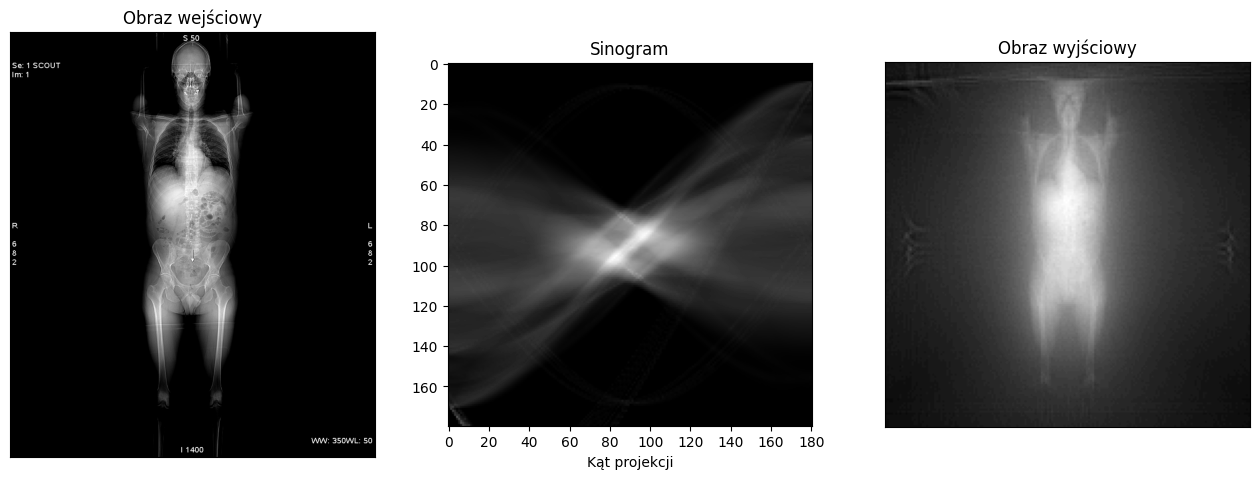

In [7]:
photo = imageio.imread('CT_ScoutView.jpg', mode = 'F')

plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0.2)
sub1 = plt.subplot(131)
sub1.set_title("Obraz wejściowy")
sub1.set_xticks([],[])
sub1.set_yticks([],[])
sub1.imshow(photo, cmap='gray')


sinogram = radon_transform(photo, d_a, range_pi, n_detect, d_x)

xlabels=[i*20 for i in range(10)]
sub2 = plt.subplot(132)
sub2.set_xticks(np.arange(0, 181/d_x, 20/d_x))
sub2.set_xticklabels(xlabels)
sub2.set_xlabel("Kąt projekcji")
sub2.set_title("Sinogram")
sub2.imshow(sinogram, cmap='gray')


if filter == True:
    sinogram2 = filtration(sinogram)
else: 
    sinogram2 = sinogram
constr, projection = back_projection(sinogram2, d_x)

sub3 = plt.subplot(133)
sub3.set_title("Obraz wyjściowy")
sub3.set_xticks([],[])
sub3.set_yticks([],[])
sub3.imshow(constr, cmap='gray')

## **Iteracyjna prezentacja**
Użyjemy suwaka, żeby pokazać rekonstrukcję w iteracji

interactive(children=(FloatSlider(value=181.0, description='Liczba iteracji:', max=181.0, min=1.0, step=1.0), …

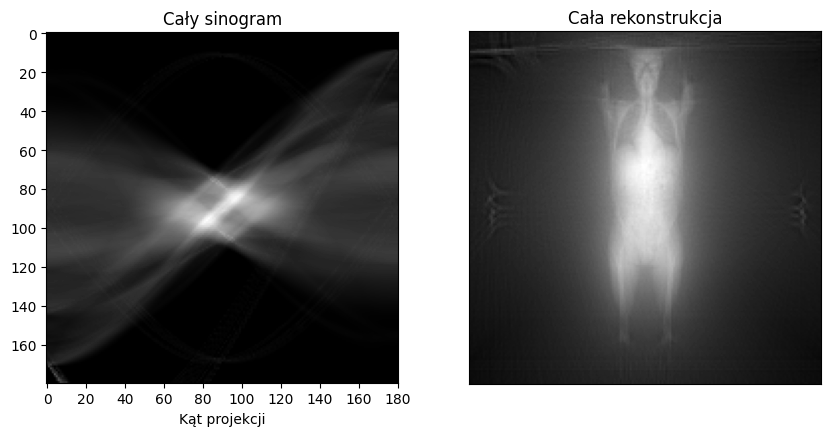

In [8]:
def number_of_iter(iteration):
    global plt
    num_iter = iteration
    
    plt.figure(figsize=(10,10))
    xlabels = [i * 20 for i in range(10)]

    global sub_sinogram_part, sub_reconstruction_part, projection

    sinogram2 = np.zeros_like(sinogram)
    sinogram2[:, :int(num_iter)] = sinogram[:, :int(num_iter)]

    sub_sinogram_part = plt.subplot(121)
    sub_sinogram_part.set_xticks(np.arange(0, 181/d_x, 20/d_x))
    sub_sinogram_part.set_xticklabels(xlabels)
    sub_sinogram_part.set_xlabel("Kąt projekcji")
    sub_sinogram_part.set_title(f"Sinogram po {int(num_iter)} iteracjach")
    sub_sinogram_part.imshow(sinogram2, cmap='gray')

    reconstruction = sum(projection[:int(num_iter) + 1])
    
    sub_reconstruction_part = plt.subplot(122)
    sub_reconstruction_part.set_title(f"Rekonstrukcja po {int(num_iter)} iteracjach")
    sub_reconstruction_part.set_xticks([],[])
    sub_reconstruction_part.set_yticks([],[])
    sub_reconstruction_part.imshow(reconstruction, cmap='gray')


interact(number_of_iter , iteration=widgets.FloatSlider(description='Liczba iteracji:', min=1,max=int(math.ceil(180/d_x)+1),step=1,value=int(math.ceil(180/d_x)+1)))

plt.figure(figsize=(10,10))
xlabels=[i*20 for i in range(10)]

sub_sinogram_full = plt.subplot(121)
sub_sinogram_full.set_xticks(np.arange(0, 181/d_x, 20/d_x))
sub_sinogram_full.set_xticklabels(xlabels)
sub_sinogram_full.set_xlabel("Kąt projekcji")
sub_sinogram_full.set_title("Cały sinogram")
sub_sinogram_full.imshow(sinogram, cmap='gray')

sub_reconstruction_full = plt.subplot(122)
sub_reconstruction_full.set_title("Cała rekonstrukcja")
sub_reconstruction_full.set_xticks([],[])
sub_reconstruction_full.set_yticks([],[])
sub_reconstruction_full.imshow(sum(projection), cmap='gray')

## **Format Dicom**
Odczyt i zapis uzyskanego obrazu w standardzie DICOM wraz z uwzględnieniem (możliwość wprowadzenia z interfejsu)

### Odczyt nowego zdjęcia JPG

In [41]:
new_photo = imageio.imread('CT_ScoutView.JPG', mode='F')
sinogram_new = radon_transform(new_photo, d_a, range_pi, n_detect, d_x)

interact(use_alfa , x=widgets.FloatSlider(description='Krok alfa:', min=0.25,max=5.0 , step=0.25,value=d_x))
interact(use_detectors ,x=widgets.IntSlider (description= 'Liczba detektorów:', min=10,max  = 500, step=10, value=n_detect))
interact(use_range_pi ,x = widgets.IntSlider (description= 'Rozpiętość:', min=0 , max= 360, step=10, value=range_pi/math.pi/2*180))
interact(use_filter , x =widgets.Checkbox(value=True, description='Filtrowanie', indent=filter))

if filter == True:
    sinogram_new2 = filtration(sinogram_new)
else: 
    sinogram_new2 = sinogram
constr_new, projection_new = back_projection(sinogram_new2, d_x)

interactive(children=(FloatSlider(value=1.0, description='Krok alfa:', max=5.0, min=0.25, step=0.25), Output()…

interactive(children=(IntSlider(value=180, description='Liczba detektorów:', max=500, min=10, step=10), Output…

interactive(children=(IntSlider(value=60, description='Rozpiętość:', max=360, step=10), Output()), _dom_classe…

interactive(children=(Checkbox(value=True, description='Filtrowanie'), Output()), _dom_classes=('widget-intera…

### Zapis DCM

In [46]:
def create_dicom(name_patient, date_patient, commentary_patient):
    global constr_new  
    photo_dcm = (constr_new).astype(np.uint16)

    meta = pydicom.Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    Data = pydicom.Dataset()
    Data.file_meta = meta
    Data.is_little_endian = True
    Data.is_implicit_VR = False
    Data.SOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
    Data.PatientName = name_patient
    Data.StudyDate = date_patient
    Data.StudyDescription = commentary_patient
    Data.Modality = "MR"
    Data.SeriesInstanceUID = pydicom.uid.generate_uid()
    Data.StudyInstanceUID = pydicom.uid.generate_uid()
    Data.FrameOfReferenceUID = pydicom.uid.generate_uid()

    Data.BitsAllocated = 16
    Data.BitsStored = 16
    Data.HighBit = 15
    Data.SamplesPerPixel = 1
    Data.ImagesInAcquisition = "1" 
    Data.Rows = photo_dcm.shape[0]
    Data.Columns = photo_dcm.shape[1]

    Data.ImagePositionPatient = r"0\0\1"
    Data.ImageOrientationPatient = r"1\0\0\0\-1\0"
    Data.ImageType = r"ORIGINAL\PRIMARY\AXIAL"
    Data.RescaleIntercept = "0"
    Data.RescaleSlope = "1"
    Data.PixelSpacing = r"1\1"
    Data.PhotometricInterpretation = "MONOCHROME2"
    Data.PixelRepresentation = 1

    pydicom.dataset.validate_file_meta(Data.file_meta, enforce_standard=True)
    Data.PixelData = photo_dcm.tobytes()
    Data.save_as("DICOM.dcm")



name_patient = "Adam Nowicki"
date_patient = "19/03/2024"
commentary_patient = "Zdjecie z tomografu komputerowego"

create_dicom(name_patient, date_patient, commentary_patient)

### Odczyt DCM

Informacje
Imie i nazwisko:  Adam Nowicki
Data:  19/03/2024
Komentarz:  Zdjecie z tomografu komputerowego


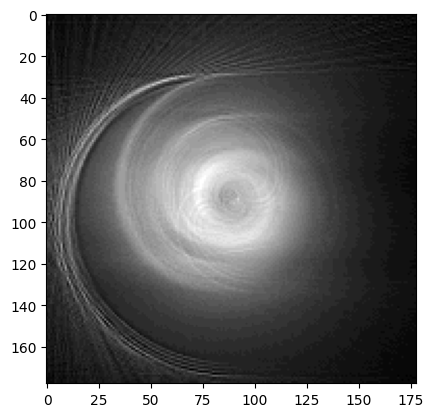

In [47]:
def open_dicom(name_dcm):
    information = pydicom.dcmread(name_dcm, force=True)
    name_patient = information.PatientName
    date_patient = information.StudyDate
    commentary_patient = information.StudyDescription
    print("Informacje")
    print("Imie i nazwisko: ", name_patient)
    print("Data: ", date_patient)
    print("Komentarz: ", commentary_patient)
    plt.imshow(information.pixel_array,cmap="gray")


open_dicom("DICOM.dcm")

## **Obliczanie błędu średniokwadratowego**

In [12]:
import numpy as np
from skimage.metrics import mean_squared_error

def calculate_mse(image1, image2):
    return mean_squared_error(image1, image2)

def analyze_mse(original_image):
    # List to store MSE values
    mse_values = []
    detectors_number = 180

    for i in range(1, 181):
        radon_image = radon_transform(original_image, d_a, range_pi, detectors_number, d_x)
        reconstructed_image = back_projection(radon_image, d_x)
        mse = calculate_mse(original_image, reconstructed_image)
        mse_values.append(mse)

    return mse_values

def analyze_mse_sampling(original_image):
    mse_values_sampling = []

    for i in range(1, 181):
        radon_image = radon_transform(original_image, d_a * i, range_pi * i, n_detect * i, d_x)
        reconstructed_image = back_projection(radon_image, d_x)
        mse = calculate_mse(original_image, reconstructed_image)
        mse_values_sampling.append(mse)

    return mse_values_sampling

def analyze_mse_filtering(original_image, theta):
    mse_values_filtering = []

    for i in range(1, 181):
        radon_image = radon_transform(original_image, d_a, range_pi, n_detect, d_x)
        reconstructed_image = back_projection(filtration(radon_image), d_x)
        mse = calculate_mse(original_image, reconstructed_image)
        mse_values_filtering.append(mse)

    return mse_values_filtering

In [22]:
from skimage.transform import resize
# Eksperyment proszę przeprowadzić na tym samym obrazie (nie może być to jednak obraz trywialny typu kółko lub dwa kwadraty). Proszę rozważyć jego następujące warianty (parametry, które nie są modyfikowane, powinny mieć wartości domyślne): liczba detektorów zmienia się od 90 do 720 z krokiem 90,
result = []

for i in range(90, 721, 90):
    n_detect = i
    sinogram = radon_transform(photo, d_a, range_pi, n_detect, d_x)
    sinogram2 = filtration(sinogram)
    constr, projection = back_projection(sinogram2, d_x)
    # check if dimensions are the same
    if constr.shape != photo.shape:
        constr = resize(constr, photo.shape)
    mse = calculate_mse(photo, constr)
    print(i, mse)
    result.append((i, mse))


90 2667.707967063455
180 2667.707967070349
270 2667.707967072192
360 2667.7079670726907
450 2667.707967073009
540 2667.707967073249
630 2667.70796707337
720 2667.7079670734433


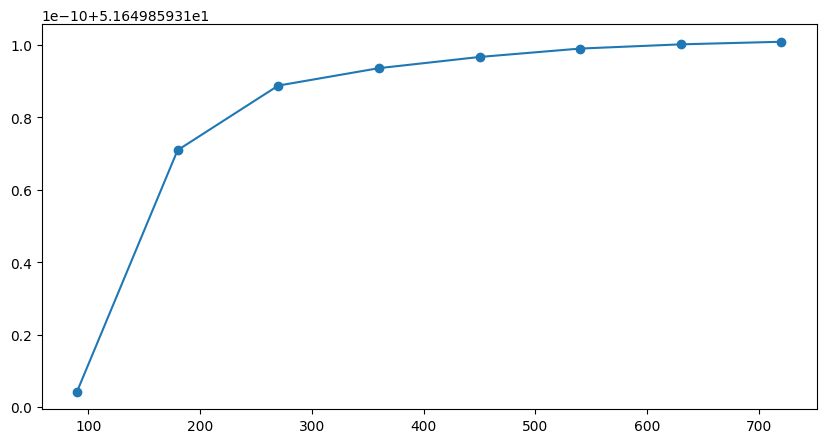

In [30]:
# Dla każdego wariantu proszę przedstawić wykres pokazujący zależność RMSE (oś Y) od aktualnej wartości zmienianego parametru (oś X) oraz krótko skomentować zaobserwowany przebieg -- zwłaszcza, czy wnioski wynikające z tego przebiegu są zgodne z oceną subiektywną jakości obrazu.

plt.figure(figsize=(10, 5))
plt.scatter([x[0] for x in result], [math.sqrt(x[1]) for x in result])
plt.plot([x[0] for x in result], [math.sqrt(x[1]) for x in result])

In [39]:
# Eksperyment proszę przeprowadzić na tym samym obrazie (nie może być to jednak obraz trywialny typu kółko lub dwa kwadraty). Proszę rozważyć jego następujące warianty (parametry, które nie są modyfikowane, powinny mieć wartości domyślne): rozpiętość wachlarza zmienia się od 45 do 270 stopni z krokiem 45 stopni.
result_2 = []
n_detect = 180
for i in range(45, 271, 45):
    # zmień rozpiętość
    range_pi = i * math.pi / 180
    
    sinogram = radon_transform(photo, d_a, range_pi, n_detect, d_x)
    sinogram2 = filtration(sinogram)
    constr, projection = back_projection(sinogram2, d_x)
    # check if dimensions are the same
    if constr.shape != photo.shape:
        constr = resize(constr, photo.shape)
    mse = calculate_mse(photo, constr)
    print(i, mse)
    result_2.append((i, mse))

45 2667.707967415659
90 2667.707967451589
135 2667.7079675098257
180 2667.7079675617924
225 2667.707967603198
270 2667.7079676343405


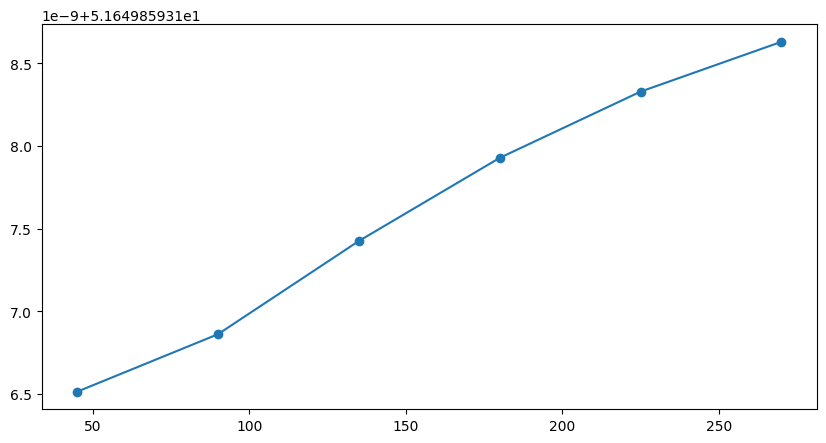

In [40]:
# narysuj wykres

plt.figure(figsize=(10, 5))
plt.scatter([x[0] for x in result_2], [math.sqrt(x[1]) for x in result_2])
plt.plot([x[0] for x in result_2], [math.sqrt(x[1]) for x in result_2])

In [48]:
result_3 = []
# Eksperyment proszę przeprowadzić na tym samym obrazie (nie może być to jednak obraz trywialny typu kółko lub dwa kwadraty). Proszę rozważyć jego następujące warianty (parametry, które nie są modyfikowane, powinny mieć wartości domyślne): liczba skanów (nie detektorów!) zmienia się od 90 do 720 z krokiem 90,
range_pi = 180
for i in range(90, 721, 90):
    d_x = 180 / i # w stopniach
    d_a = d_x * math.pi / 180 # w radianach
    
    sinogram = radon_transform(photo, d_a, range_pi, n_detect, d_x)
    sinogram2 = filtration(sinogram)
    constr, projection = back_projection(sinogram2, d_x)
    # check if dimensions are the same
    if constr.shape != photo.shape:
        constr = resize(constr, photo.shape)
    mse = calculate_mse(photo, constr)
    print(i, mse)
    result_3.append((i, mse))

90 2667.7079677262545
180 2667.7079677255283
270 2667.7079677264187
360 2667.7079677253587
450 2667.70796772603
540 2667.70796772595
630 2667.7079677261213
720 2667.707967726146


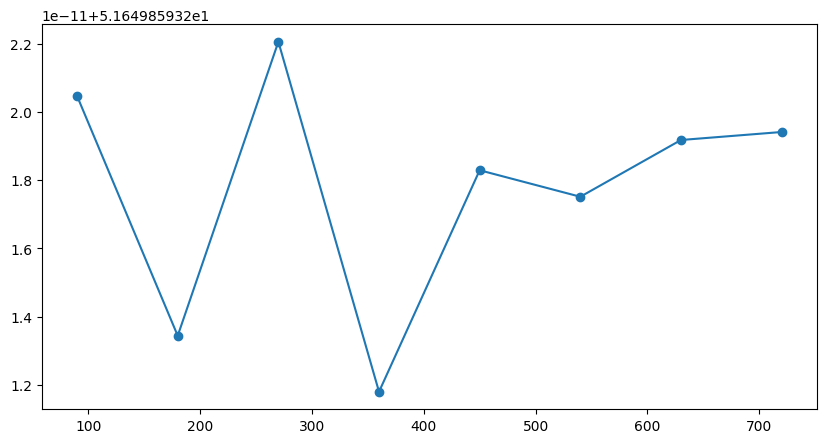

In [49]:
# narysuj wykres
plt.figure(figsize=(10, 5))
plt.scatter([x[0] for x in result_3], [math.sqrt(x[1]) for x in result_3])
plt.plot([x[0] for x in result_3], [math.sqrt(x[1]) for x in result_3])

In [51]:
# Dla dwóch wybranych obrazów oraz następujących parametrów: liczba detektorów = 360, liczba skanów = 360, rozpiętość wachlarza = 270 stopni, proszę wykonać dwa warianty obliczeń -- z włączonym i wyłączonym filtrowaniem sinogramu. Dla każdego obrazu proszę zaprezentować RMSE dla obrazu bez filtrowania i z filtrowaniem oraz krótko skomentować różnice w jakości między obrazami.

range_pi = 270 * math.pi / 180
n_detect = 360
d_x = 180 / 360
d_a = d_x * math.pi / 180

# bez filtrowania
sinogram = radon_transform(photo, d_a, range_pi, n_detect, d_x)
constr, projection = back_projection(sinogram, d_x)

# z filtrowaniem
sinogram_2 = filtration(sinogram)
constr_2, projection_2 = back_projection(sinogram_2, d_x)

# dostosuj wymiary constr i constr_2 do photo
if constr.shape != photo.shape:
    constr = resize(constr, photo.shape)

if constr_2.shape != photo.shape:
    constr_2 = resize(constr_2, photo.shape)
mse_1 = calculate_mse(photo, constr)
mse_2 = calculate_mse(photo, constr_2)



2667.7079676049393 2667.7079676017383


In [52]:
print(math.sqrt(mse_1), math.sqrt(mse_2))

51.64985931834606 51.64985931831507
